In [2]:
 !pip install yfinance

     |████████████████████████████████| 6.3 MB 17.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=35d0ab3b5956143dbbff4a641286dc372eb37b649290c81af2b2e647830fea4c
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg 

In [4]:
def Rendimientos_log(data, tickers_list, horizonte):
  df = pd.DataFrame(columns= tickers_list)
  data_lst_2 = []
  for i in range(len(data) - horizonte):
    values = np.log(data.iloc[i+horizonte,:] / data.iloc[i,:])
    dictionary_2 = dict(zip(tickers_list, values))
    data_lst_2.append(dictionary_2)
  return df.append(data_lst_2, True)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
def MBG(n,m,t, miu, sigma, s0, m_cholesky ,fk, accion):
  plt.cla()
  dt = 1/n
  dx = np.sqrt(dt)
  k = np.zeros(shape = [int(np.floor(n*t)) + 1, m])
  tiempos = np.arange(0, np.floor(n*t) + 1, step = 1) * dt
  for i in range(m):
    aleatorios = np.random.normal(size = (int(np.floor(n*t))  ,5))
    factores_riesgo = np.transpose(m_cholesky @ np.transpose(aleatorios))
    k[0,i] = s0
    k[1:, i] =s0 * np.exp( (miu - sigma**2 / 2) * tiempos[1:] + sigma* np.cumsum(factores_riesgo[:,fk])*dx )
    sns.lineplot(x = tiempos, y = k[:,i], alpha = 0.5).set_title(label = accion)
  plt.savefig(str(accion) + '.svg' , dpi = 800) 
  plt.show()
  return k
# MBG(100,100 ,1, medias[0], desvest[0], up[0], 0, 'abdi te amo').shape

## Gráficas

In [7]:
def graficas(tickers_list,FechaInicio, FechaCierre):
  tickers_list.sort()
  data = yf.download(tickers_list,FechaInicio,FechaCierre)['Adj Close']
  fig, axes = plt.subplots(int(np.floor(len(tickers_list)/3)+1), 3, sharex=True, figsize=(20,12))
  sns.set_theme()
  fig.suptitle('Precio de Acciones')
  for i in range(len(tickers_list) ):
    sns.lineplot(x = data.index, y = tickers_list[i], data=data, ax = axes[int(np.floor(i/3)), int(i%3)]).set(title = tickers_list[i] )
  for j in range(3):
    plt.setp(axes[:, j], ylabel='Precios')
  fig.autofmt_xdate(rotation=45)

  plt.plot()

[*********************100%***********************]  5 of 5 completed


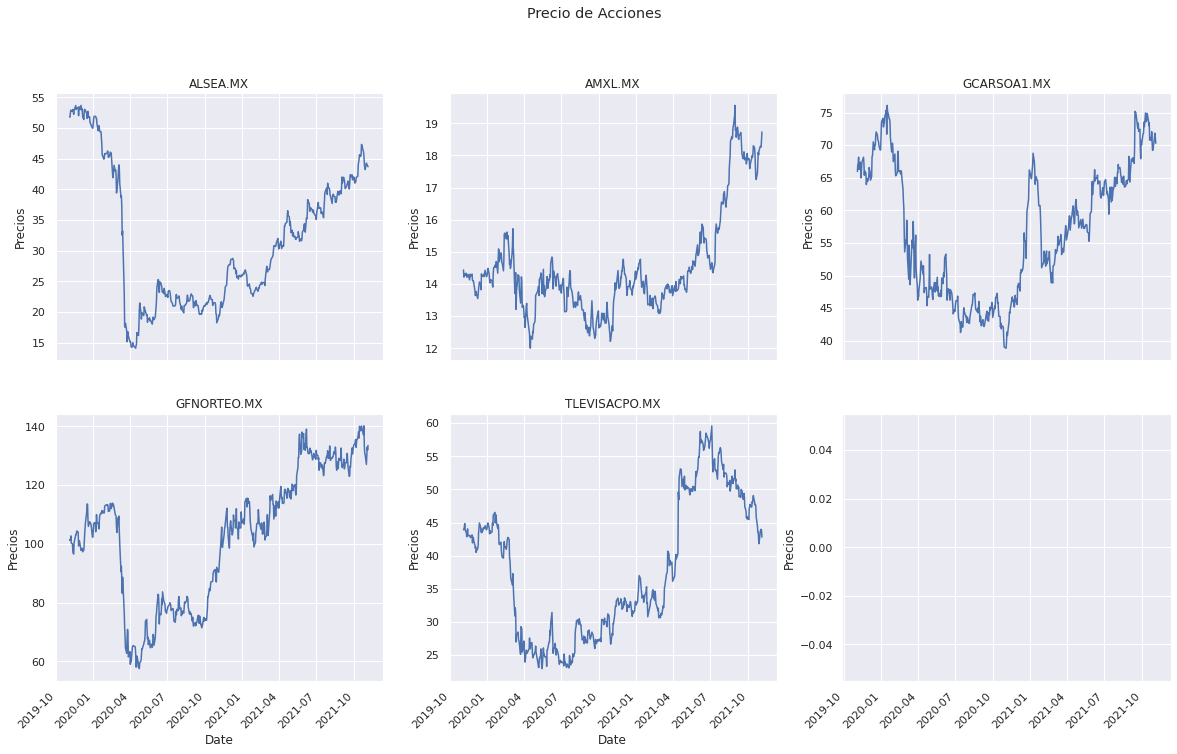

In [8]:
graficas(['GCARSOA1.MX','ALSEA.MX', 'GFNORTEO.MX', 'AMXL.MX','TLEVISACPO.MX'], '2019-11-03', 
               '2021-11-08')

## VaR Paramétrico

In [9]:
def VaRParametrico(tickers_list, FechaInicio, FechaCierre, Horizonte, A, Posicion):
  tickers_list.sort()
  data = yf.download(tickers_list,FechaInicio,FechaCierre)['Adj Close']
  rendimientos_p = Rendimientos_log(data, tickers_list, 1)
  M = np.mean(rendimientos_p, axis = 0) 
  Mcov = rendimientos_p.cov() 
  Zq = np.array([norm.ppf(0.95), norm.ppf(0.99)])
  Mport = M @ np.transpose(A)
  SPort = np.sqrt( (A @ Mcov) @ np.transpose(A) )
  Var = Mport * (Horizonte) - Zq * SPort * (Horizonte ** (1/2))
  VAR_Port = pd.DataFrame(Var, index = ['95%', '99%'], columns = ['VAR del Portafolio'])
  return VAR_Port * Posicion
  

In [10]:
VaRParametrico(['GCARSOA1.MX','ALSEA.MX', 'GFNORTEO.MX', 'AMXL.MX','TLEVISACPO.MX'], '2019-11-03', 
               '2021-11-08',1, [1/5,1/5,1/5,1/5,1/5], 1000000)

[*********************100%***********************]  5 of 5 completed


,VAR del Portafolio
95%,-30717.634061
99%,-43510.779926


## VaR Simulación histórica

In [11]:
def VaRSh(tickers_list, FechaInicio, FechaCierre, Horizonte, A, Posicion):
  tickers_list.sort()
  data = yf.download(tickers_list,FechaInicio,FechaCierre)['Adj Close']
  up = data.iloc[-1,:]
  titles = np.array([ A[i]* Posicion/ up[i]  for i in range(5) ])
  titles = pd.DataFrame(titles, index= tickers_list,columns=['TITLES'])
  lst_port = []
  for i in range(len(data)):
    lst_port.append( np.dot(data.iloc[i,:], titles.values)[0])
  escenarios_portafolio = pd.DataFrame(lst_port, columns=['Precios Portafolio'])
  variaciones_sim = Rendimientos_log(escenarios_portafolio, ['Variaciones Sim'], Horizonte)
  precio_port_sim = Posicion *(1 + variaciones_sim)
  variaciones_sim_2 = np.log(precio_port_sim / Posicion)
  VaR = pd.DataFrame(np.percentile(variaciones_sim_2,[5, 1]), index = ['95%', '99%'], columns=['VaR'])
  
  return VaR * Posicion



In [12]:
VaRSh(['GCARSOA1.MX','ALSEA.MX', 'GFNORTEO.MX', 'AMXL.MX','TLEVISACPO.MX'], '2019-11-03', 
               '2021-11-08',1, [1/5,1/5,1/5,1/5,1/5], 1000000)

[*********************100%***********************]  5 of 5 completed


,VaR
95%,-26793.625254
99%,-66193.390870


## VaR Simulación Monte Carlo

In [13]:
def VaRSMC(tickers_list, FechaInicio, FechaCierre, Horizonte, A, Posicion):
  tickers_list.sort()
  data = yf.download(tickers_list,FechaInicio,FechaCierre)['Adj Close']
  rendimientos_smc = Rendimientos_log(data, tickers_list, 1)
  mcovmc = rendimientos_smc.cov()
  m_cholesky = scipy.linalg.cholesky(mcovmc, lower=True)
  medias = np.mean(rendimientos_smc, axis=0)
  desvest = np.std(rendimientos_smc, axis = 0)
  up_mc = data.iloc[-1,:]
  titles_mc = np.array([ A[i]* Posicion/ up_mc[i]  for i in range(5) ])
  titles_mc = pd.DataFrame(titles_mc, index= tickers_list,columns=['TITLES'])
  precios_simulados_mc = np.ndarray(shape = (1000, 5))
  for i in range(5):
    precios_simulados_mc[:,i] =  MBG(40,1000 ,Horizonte, medias[i], desvest[i], up_mc[i], m_cholesky, i, tickers_list[i])[-1, : ]
  precio_port_sim_mc = np.dot(precios_simulados_mc, titles_mc)
  variaciones_finales = np.log(precio_port_sim_mc/Posicion)
  VaR_mc = pd.DataFrame(np.percentile(variaciones_finales,[5, 1]), index = ['95%', '99%'], columns=['VaR Monte Carlo'])
  
  return VaR_mc * Posicion

[*********************100%***********************]  5 of 5 completed


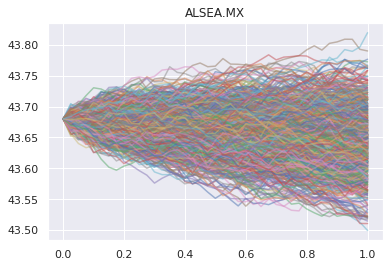

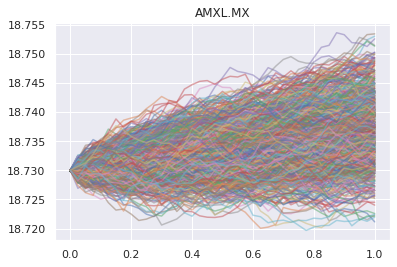

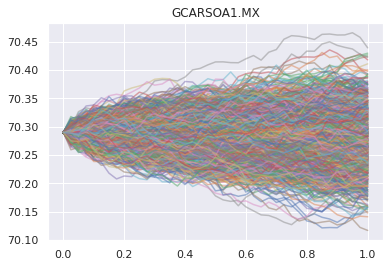

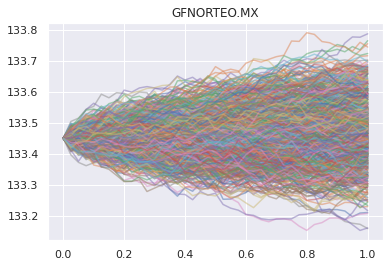

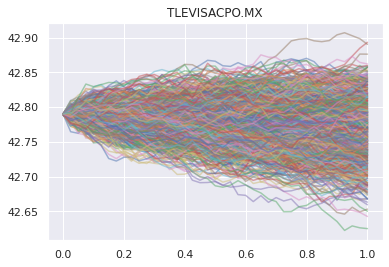

,VaR Monte Carlo
95%,-798.745158
99%,-1100.714159


In [14]:
VaRSMC(['GCARSOA1.MX','ALSEA.MX', 'GFNORTEO.MX', 'AMXL.MX','TLEVISACPO.MX'], '2019-11-03', 
               '2021-11-08',1, [1/5,1/5,1/5,1/5,1/5], 1000000)